<a href="https://colab.research.google.com/github/RodrigodeFeo/8DTS/blob/main/Trabalho_Integrado_CV_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trabalho integrado de Computer Vision 8DTS

- RM351578 - RODRIGO DE FEO VIEIRA
- RM351070 - DANILO DOS SANTOS DA FONTE
- RM350640 - FELIPE FIORIM CARVALHO SILVA
- RM352054 - GABRIEL GONSALVES DE ALMEIDA

Considerações importantes:
Oi Prof Felipe! Antes de iniciar a revisão do trabalho, precisamos te passar como funciona a estrutura deste script.

- Para conseguirmos fazer funcionar no Colab utilizamos Javascript para acessar a WebCam do notebook
- Nao conseguimos automatizar a detectao da vivacidade automaticamente e pausar a camera entao deve ser utilizado os botoes de Capturar Foto e Prova de Vida manualmente
- Para capturar a Foto aproxime se da camera e abra os olhos, e para a prova de vida pisque e clique em prova de vida
- Realize o upload de alguma foto de rosto para servir como o cadastro do cliente

Passo 1
-Vamos importar as bibliotecas

In [5]:
!pip install opencv-python-headless
!pip install mediapipe
!pip install dlib
!pip install face_recognition
!pip install google-colab
!pip install deepface

  Using cached face_recognition-1.3.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached face_recognition_models-0.3.0.tar.gz (100.1 MB)
  Preparing metadata (setup.py) ... done
Using cached face_recognition-1.3.0-py2.py3-none-any.whl (15 kB)
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566164 sha256=8b0d9d66d212f2ccf0f56c7717b2189030d81c503d4d532759b464706c9de6f8
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


Passo 2 - Para Simular o cadastro realize o upload de uma foto de rosto para servir como o cadastro do cliente

In [35]:
#Para simular um cadastro previo vamos fazer o upload da foto do cliente que sera utilizada para a comparacao com a lida pela camera
import os
from google.colab import files

# Cria uma interface para o upload de arquivos
uploaded = files.upload()

# Listar os nomes dos arquivos que foram enviados
for filename in uploaded.keys():
    print(f'Arquivo {filename} enviado com sucesso!')

# Renomeie o arquivo
if os.path.exists(filename):
    os.rename(filename, "foto_cadastro.jpg")


Saving fotocomoculos.jpg to fotocomoculos.jpg
Arquivo fotocomoculos.jpg enviado com sucesso!


Passo 3 - Criamos essa trava para a validacao do cliente apenas ser realizada apos a prova de vida ser capturada

In [25]:
cliente_vivo = False

Passo 4 - Vamos importar a biblioteca para detectarmos face nas imagens

In [3]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2024-07-29 01:16:59--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  39.3MB/s    in 1.6s    

2024-07-29 01:17:01 (39.3 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



Passo 5 - Essa e a funcao que captura a imagem da Webcam e detecta a Face para futuramente compararmos com a foto do cadastro do cliente

In [29]:
import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow
from google.colab import output
import base64
import dlib
import os

# Caminho do arquivo que você deseja verificar e excluir
file_path = '/content/captured_frame_det.jpg'

# Verifica se o arquivo existe
if os.path.exists(file_path):
    # Exclui o arquivo
    os.remove(file_path)


# Inicializa a detecção facial com mediapipe
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Carrega o detector de marcos faciais de dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Função para calcular a razão de aspecto do olho (EAR)
def eye_aspect_ratio(eye):
    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])
    C = np.linalg.norm(eye[0] - eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

# Limite para detectar piscadas
EYE_AR_THRESH = 0.21

# Função para processar o frame
def process_frame(data):
    # Decodifica a imagem
    image_data = data.split(",")[1]
    image = np.frombuffer(base64.b64decode(image_data), dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    # Converte a imagem para RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Processa a imagem para detecção facial
    results = face_detection.process(rgb_image)

    # Desenha as detecções faciais na imagem
    if results.detections:
        for detection in results.detections:
            mp_drawing.draw_detection(image, detection)

        # Converte a imagem para escala de cinza
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detecta faces na imagem
        rects = detector(gray, 0)

        for rect in rects:
            shape = predictor(gray, rect)
            shape = np.array([[p.x, p.y] for p in shape.parts()])

            leftEye = shape[42:48]
            rightEye = shape[36:42]
            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)

            ear = (leftEAR + rightEAR) / 2.0

            # Desenha os olhos na imagem
            for (x, y) in leftEye:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
            for (x, y) in rightEye:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

            # Verifica se houve piscada
            if ear < EYE_AR_THRESH:
                cv2.putText(image, "Piscada Detectada!", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                print("Piscada Detectada!")
                # Exibe a imagem processada
                cv2_imshow(image)
                # Salva a imagem no ambiente do Colab
                cv2.imwrite('/content/captured_frame_det.jpg', image)
                print('Imagem salva em /content/captured_frame_det.jpg')
                global cliente_vivo
                cliente_vivo = True
            else:
                cv2.putText(image, "Piscada Nao Detectada!", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                cv2.imwrite('/content/captured_n_frame.jpg', image)
                print("Piscada Não Detectada!")



# Registro da função para receber frames
output.register_callback('notebook.get_frame', process_frame)

Passo 6 - Essa e a funcao que realiza a proca de vida, neste caso utilizamos a tecnica de captura de piscada para identificar se o cliente esta vivo

In [26]:
import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow
from google.colab import output
import base64
import dlib
import os

# Caminho do arquivo que você deseja verificar e excluir
file_path = '/content/captured_frame.jpg'

# Verifica se o arquivo existe
if os.path.exists(file_path):
    # Exclui o arquivo
    os.remove(file_path)


# Inicializa a detecção facial com mediapipe
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Carrega o detector de marcos faciais de dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Função para calcular a razão de aspecto do olho (EAR)
def eye_aspect_ratio(eye):
    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])
    C = np.linalg.norm(eye[0] - eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

# Limite para detectar piscadas
EYE_AR_THRESH = 0.21

# Função para processar o frame
def take_pic(data):
    # Decodifica a imagem
    image_data = data.split(",")[1]
    image = np.frombuffer(base64.b64decode(image_data), dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    #Salva imagem sem face detect
    cv2.imwrite('/content/captured_frame.jpg', image)
    print('Imagem salva em /content/captured_frame.jpg')

    # Converte a imagem para RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Processa a imagem para detecção facial
    results = face_detection.process(rgb_image)

    # Desenha as detecções faciais na imagem
    if results.detections:
        for detection in results.detections:
            mp_drawing.draw_detection(image, detection)

        # Converte a imagem para escala de cinza
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detecta faces na imagem
        rects = detector(gray, 0)

        for rect in rects:
            shape = predictor(gray, rect)
            shape = np.array([[p.x, p.y] for p in shape.parts()])

            leftEye = shape[42:48]
            rightEye = shape[36:42]
            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)

            ear = (leftEAR + rightEAR) / 2.0

            # Desenha os olhos na imagem
            for (x, y) in leftEye:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
            for (x, y) in rightEye:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

            cv2.putText(image, "Capturado Foto para AUTENTICACAO!", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            # Exibe a imagem processada
            cv2_imshow(image)
            cv2.imwrite('/content/captured_face_frame.jpg', image)
            print("Capturado Foto para AUTENTICACAO!")


# Registro da função para receber frames
output.register_callback('notebook.take_pic', take_pic)

Passo 7 - Vamos utilizar a tecnica de Javascript para poder acessar a WebCam do notebook via Colab

Imagem salva em /content/captured_frame.jpg


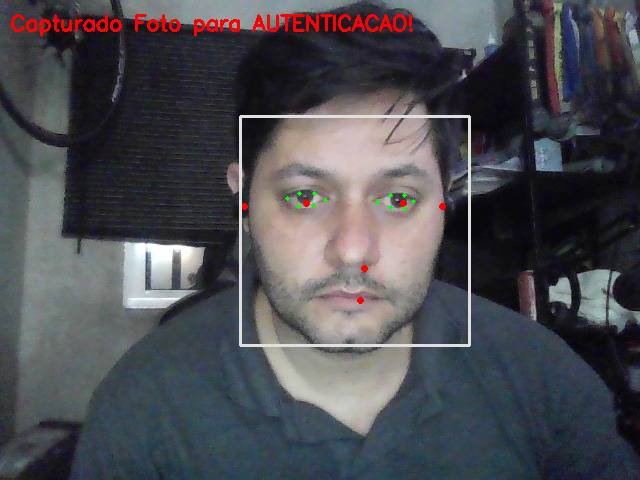

Capturado Foto para AUTENTICACAO!
Piscada Não Detectada!
Piscada Detectada!


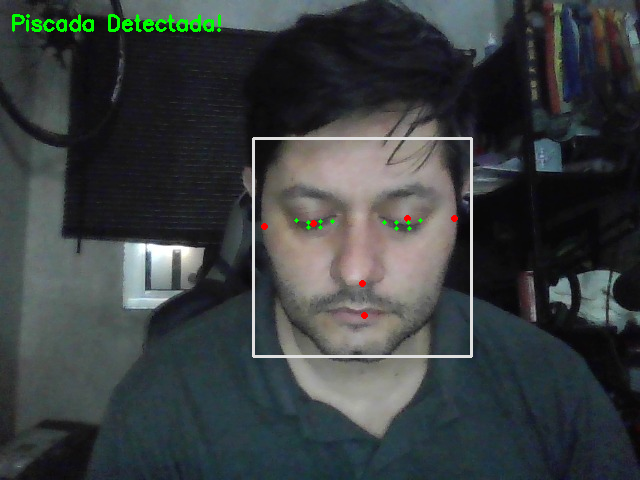

Imagem salva em /content/captured_frame_det.jpg


In [33]:
from IPython.display import display, Javascript, HTML

HTML('''
<video autoplay playsinline id="video" width="640" height="480"></video>
<button id="captureButton">Capturar Foto</button>
<button id="vivacitiButton">Prova de Vida</button>
<button id="stopButton">Parar Webcam</button>
<button id="startButton">Iniciar Webcam</button>
<script>
  const video = document.getElementById('video');
  const button = document.getElementById('captureButton');
  let stream;

  async function setupCamera() {
    stream = await navigator.mediaDevices.getUserMedia({ video: true });
    video.srcObject = stream;
    await new Promise((resolve) => (video.onloadedmetadata = resolve));
    video.play();
  }

  async function stopCamera() {
    if (stream) {
      stream.getTracks().forEach((track) => track.stop());
      stream.srcObject = null;
      stream = null;
    }
  }

  async function startCamera() {
    await stopCamera();
    await setupCamera();
  }

 function captureFotoFrame() {
    const canvas = document.createElement('canvas');
    canvas.width = video.videoWidth;
    canvas.height = video.videoHeight;
    const context = canvas.getContext('2d');
    context.drawImage(video, 0, 0, canvas.width, canvas.height);
    const data = canvas.toDataURL('image/jpeg');
    google.colab.kernel.invokeFunction('notebook.take_pic', [data], {});
  }


  function captureFrame() {
    const canvas = document.createElement('canvas');
    canvas.width = video.videoWidth;
    canvas.height = video.videoHeight;
    const context = canvas.getContext('2d');
    context.drawImage(video, 0, 0, canvas.width, canvas.height);
    const data = canvas.toDataURL('image/jpeg');
    google.colab.kernel.invokeFunction('notebook.get_frame', [data], {});
  }

  button.onclick = async function() {
    captureFrame();
  }

  stopButton.onclick = async function() {
    await stopCamera();
  }

  startButton.onclick = async function() {
    await startCamera();
  }

  captureButton.onclick = async function() {
    await captureFotoFrame();
  }

  vivacitiButton.onclick = async function() {
    await captureFrame();
  }

</script>
''')

Passo 8 - Agora vamos agora utilizar a biblioteca Deepface para realizar a comparacao das fotos do cadastro do cliente e da foto capturada para realizar a Autenticacao no sistema

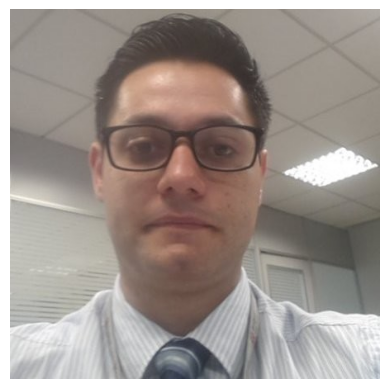

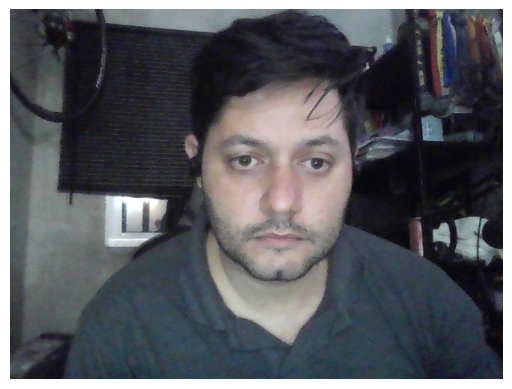

Cliente não identificado na foto NAO AUTENTICADO


In [36]:
from deepface import DeepFace

def comparar_faces(foto1_path, foto2_path):
    # Comparar as imagens usando DeepFace
    # Ensure the paths are correct and the files exist
    if not os.path.exists(foto1_path):
        raise FileNotFoundError(f"File not found: {foto1_path}")
    if not os.path.exists(foto2_path):
        raise FileNotFoundError(f"File not found: {foto2_path}")

    resultado = DeepFace.verify(foto1_path, foto2_path)
    return resultado['verified']

# Vamos comparar as fotos verificando se trata-se do cliente
foto1 = '/content/foto_cadastro.jpg'
foto2 = '/content/captured_frame.jpg'

resultado = comparar_faces(foto1, foto2)

import cv2
from matplotlib import pyplot as plt

def exibir_imagem(imagem_path):
    img = cv2.imread(imagem_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# Exibir as imagens para verificação
exibir_imagem(foto1)
exibir_imagem(foto2)


if resultado and cliente_vivo:
    print("Cliente identificado na foto AUTENTICADO.")
else:
   print("Cliente não identificado na foto NAO AUTENTICADO")
